In [1]:
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler


CURR_DIR_PATH = os.path.dirname(os.curdir)
DATASET_DIR_PATH = os.path.join(CURR_DIR_PATH, '..', 'DataSets', 'turismo_spain_ccaa')

sys.path.insert(1, os.path.join(CURR_DIR_PATH, '..', 'paquetes_base_dvd'))
import api_datos_gob
import analitica_base
import operaciones_bbdd_postgresql as bd


In [2]:
url_data = "ea0010587-numero-de-turistas-por-ccaa-y-provincia-de-destino-desagregados-por-provincia-de-origen-tmov-identificador-api-53267"
# api_datos_gob.get_and_download(url_data, DATASET_DIR_PATH)

# CAPA BRONZE - Carga y Revisión Inicial
analitica_base.bronze_file_info(os.path.join(DATASET_DIR_PATH,url_data+'.csv'))
df_turismo = pd.read_csv(url_data+'.csv', sep=';', on_bad_lines='skip', thousands = '.')
analitica_base.bronze_df_basic_stats(df_turismo)
analitica_base.display_df(df_turismo)

--------Información básica fichero ------------
Tamaño archivo: 22.252478 MB
Fecha ultimo acceso: 2025-07-07 13:05:50
Fecha ultima modificación: 2025-07-03 12:06:56
Fecha cambio metadatos: 2025-07-03 12:07:28
-----------------------------------------------
---------ENCABEZADOS------------
NCols: 8
NRows: 267120
Cabecera: ['Provincia de origen', 'Provincia de origen.1', 'CCAA y provincia de destino', 'CCAA y provincia de destino.1', 'CCAA y provincia de destino.2', 'Concepto turístico', 'Periodo', 'Total']
---------TIPOS------------
Ind types: Provincia de origen              string[python]
Provincia de origen.1            string[python]
CCAA y provincia de destino      string[python]
CCAA y provincia de destino.1    string[python]
CCAA y provincia de destino.2    string[python]
Concepto turístico               string[python]
Periodo                          string[python]
Total                            string[python]
dtype: object
-------------------------------------------------
---

,Provincia de origen,Provincia de origen.1,CCAA y provincia de destino,CCAA y provincia de destino.1,CCAA y provincia de destino.2,Concepto turístico,Periodo,Total
0,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M04,14.079.139
1,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M03,12.157.520
2,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M02,11.647.181
3,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M01,13.235.172
4,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2024M12,14.579.488


In [3]:
# CAPA BRONZE - Columnas Eliminacion incorrectas y renombrado

df_turismo = df_turismo.drop(columns=["Provincia de origen", "CCAA y provincia de destino", "Concepto turístico"])
df_turismo = df_turismo.rename(columns={"Provincia de origen.1":"prov_origen", 
                                        "CCAA y provincia de destino.1":"ccaa_destino", 
                                        "CCAA y provincia de destino.2":"prov_destino",
                                        "Periodo":"periodo",
                                        "Total":"total"})
analitica_base.display_df(df_turismo)


,prov_origen,ccaa_destino,prov_destino,periodo,total
0,NaN,NaN,NaN,2025M04,14.079.139
1,NaN,NaN,NaN,2025M03,12.157.520
2,NaN,NaN,NaN,2025M02,11.647.181
3,NaN,NaN,NaN,2025M01,13.235.172
4,NaN,NaN,NaN,2024M12,14.579.488


In [4]:
# CAPA BRONZE - Data Profiling - Formato fechas
df_turismo['periodo'] = df_turismo['periodo'].str.replace('M', "-")
df_turismo['periodo'] = pd.to_datetime(df_turismo['periodo'] + '-01', format='%Y-%m-%d')
analitica_base.display_df(df_turismo)

,prov_origen,ccaa_destino,prov_destino,periodo,total
0,NaN,NaN,NaN,2025-04-01,14.079.139
1,NaN,NaN,NaN,2025-03-01,12.157.520
2,NaN,NaN,NaN,2025-02-01,11.647.181
3,NaN,NaN,NaN,2025-01-01,13.235.172
4,NaN,NaN,NaN,2024-12-01,14.579.488


In [5]:
# CAPA BRONZE - Data Profiling - Tratamiento NULLS
df_turismo = df_turismo[pd.notna(df_turismo['prov_destino'])]
df_turismo = df_turismo[pd.notna(df_turismo['ccaa_destino'])]
df_turismo = df_turismo[pd.notna(df_turismo['prov_origen'])]
df_turismo = df_turismo[['periodo', 'prov_origen', 'prov_destino', 'total']]
analitica_base.display_df(df_turismo)

,periodo,prov_origen,prov_destino,total
5180,2025-04-01,Ourense,Almería,294
5181,2025-03-01,Ourense,Almería,222
5182,2025-02-01,Ourense,Almería,140
5183,2025-01-01,Ourense,Almería,74
5184,2024-12-01,Ourense,Almería,111


In [6]:
# CAPA BRONZE - Data Profiling - Tratamiento NULLS
df_total_nas_check = df_turismo[(df_turismo['total'] == '.') | (df_turismo['total'].isna())]

# CAPA BRONZE - Data Profiling - Formato columna total texto -> entero
df_turismo = df_turismo[df_turismo['total'] != '.']
df_turismo = df_turismo[df_turismo['total'].notna()]
df_turismo['total'] = df_turismo['total'].str.replace('.','')
df_turismo['total'] = df_turismo['total'].astype('int')


                             periodo         total
count                         177767  1.777670e+05
mean   2022-05-19 04:40:33.144509696  5.586204e+03
min              2019-07-01 00:00:00  3.000000e+01
25%              2020-12-01 00:00:00  3.620000e+02
50%              2022-06-01 00:00:00  8.990000e+02
75%              2023-11-01 00:00:00  2.877000e+03
max              2025-04-01 00:00:00  1.034493e+06
std                              NaN  2.208489e+04


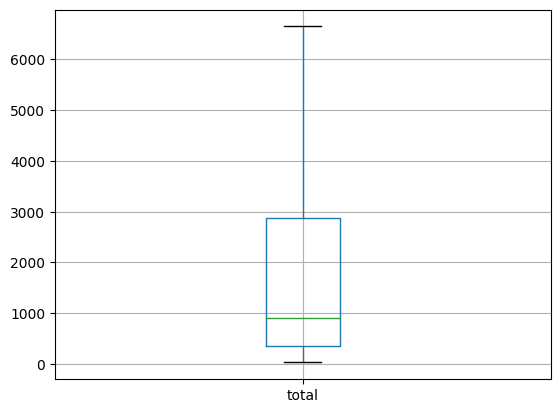

In [7]:
# CAPA BRONZE - Data Profiling - Busqueda Outliers
print(df_turismo[['periodo', 'total']].describe())
ax1 = df_turismo.boxplot(column=['total'], showfliers = False)
# ax1 = df_turismo.boxplot(column=['total'])

In [8]:
analitica_base.bronze_df_basic_stats(df_turismo)
analitica_base.display_df(df_turismo)

---------ENCABEZADOS------------
NCols: 4
NRows: 177767
Cabecera: ['periodo', 'prov_origen', 'prov_destino', 'total']
---------TIPOS------------
Ind types: periodo         datetime64[ns]
prov_origen     string[python]
prov_destino    string[python]
total                    Int32
dtype: object
-------------------------------------------------
---------NULOS------------
NA values periodo: 0
NA values prov_origen: 0
NA values prov_destino: 0
NA values total: 0
-------------------------------------------------
---------UNICOS------------
Unique values periodo: [Timestamp('2019-07-01 00:00:00'), Timestamp('2019-08-01 00:00:00'), Timestamp('2019-09-01 00:00:00'), Timestamp('2019-10-01 00:00:00'), Timestamp('2019-11-01 00:00:00'), Timestamp('2019-12-01 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2020-02-01 00:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-07-01 00:00:

,periodo,prov_origen,prov_destino,total
5180,2025-04-01,Ourense,Almería,294
5181,2025-03-01,Ourense,Almería,222
5182,2025-02-01,Ourense,Almería,140
5183,2025-01-01,Ourense,Almería,74
5184,2024-12-01,Ourense,Almería,111


In [9]:
#----------------------FIN CAPA BRONZE--------------------------#
#-----------------DATOS CSV EN CALIDAD SILVER ------------------#

In [ ]:
# CAPA SILVER - Preparación de tablas SILVER para inserción en BD
# Excel ccaa y provincias obtenidos de web oficial INE para codigos identificadores
df_ccaas = pd.read_excel('codccaa.xls')
df_provincias = pd.read_excel('codprov.xls')
df_ccaas = df_ccaas.convert_dtypes()
df_provincias = df_provincias.convert_dtypes()
df_provincias.dtypes
# analitica_base.display(df_turismo)
# analitica_base.display(df_provincias)

# Turismo
df_turismo_m1 = pd.merge(
    df_turismo,
    df_provincias,
    left_on='prov_origen',
    right_on='nombre_provincia',
    how='left',
    suffixes=('', '_origen')
)
df_turismo_m1 = df_turismo_m1.rename(columns={'id_provincia':'id_provincia_origen'})
df_turismo_m1 = df_turismo_m1[['periodo','id_provincia_origen', 'prov_destino','total']]

df_turismo_m2 = pd.merge(
    df_turismo_m1,
    df_provincias,
    left_on='prov_destino',
    right_on='nombre_provincia',
    how='left',
    suffixes=('', '_origen')
)
df_turismo_m2 = df_turismo_m2.rename(columns={'id_provincia':'id_provincia_destino'})
df_turismo_m2 = df_turismo_m2[['periodo','id_provincia_origen', 'id_provincia_destino','total']]
df_turismo_m2 = df_turismo_m2.sort_values(by='periodo')
analitica_base.display(df_turismo_m2)

,periodo,id_provincia_origen,id_provincia_destino,total
92854,2019-07-01,25,3,1557
37819,2019-07-01,42,28,5073
115828,2019-07-01,18,5,670
113015,2019-07-01,19,49,616
100861,2019-07-01,23,51,133
...,...,...,...,...
5894,2025-04-01,51,29,7783
37222,2025-04-01,42,12,625
132285,2025-04-01,13,4,2405
83715,2025-04-01,27,11,601


In [ ]:
# CAPA SILVER - Insercion de tablas SILVER en BD
# op = bd.insert_df_into_table(df_ccaas, 'comunidades_autonomas', 'Datos_Gob')
# op = bd.insert_df_into_table(df_provincias, 'provincias', 'Datos_Gob')
# op = bd.insert_df_into_table(df_turismo_m2,'flujos_turismo', 'Datos_Gob')

#-----------------TABLAS SILVER CARGADAS EN BD ------------------#
#----------------------FIN CAPA SILVER--------------------------#

In [ ]:
# CAPA GOLD - CREAR VISTAS EN BD PARA PREPARARLAS CONSUMO NEGOCIO
# vista vista_flujos_turismo_españa creada en PostgreSQL lista para ingesta en PowerBI, Tableau, Looker...
#----------------------FIN CAPA GOLD--------------------------#